
# Advertising Sales — Multiple Regression (scikit-learn)

This notebook demonstrates a complete workflow for a multiple linear regression model using the classic **Advertising** dataset.

**What you'll see:**
- Data loading & quick quality checks
- Basic EDA and correlations
- Train/Test split
- A pipeline with `StandardScaler` + `LinearRegression`
- Evaluation metrics: **R², MAE, RMSE** + 5-fold CV
- Optional **Ridge** regression with grid search
- Coefficients for interpretability
- Plots: residuals and predicted vs. actual


In [3]:

# Install packages if needed (uncomment if running in a fresh environment)
# %pip install scikit-learn pandas numpy matplotlib joblib

import json
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split, GridSearchCV, cross_val_score
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LinearRegression, Ridge
from sklearn.metrics import r2_score, mean_absolute_error, mean_squared_error

import joblib

# File path (update if your CSV is elsewhere)
CSV_PATH = "Advertising.csv"


In [4]:

# Load the dataset
df = pd.read_csv(CSV_PATH)

# Drop obvious index-like columns if present
for col in ["Unnamed: 0", "index"]:
    if col in df.columns:
        df = df.drop(columns=[col])

display(df.head())
print("Shape:", df.shape)
df.info()


,TV,radio,newspaper,sales
0,230.1,37.8,69.2,22.1
1,44.5,39.3,45.1,10.4
2,17.2,45.9,69.3,9.3
3,151.5,41.3,58.5,18.5
4,180.8,10.8,58.4,12.9


Shape: (200, 4)
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 200 entries, 0 to 199
Data columns (total 4 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   TV         200 non-null    float64
 1   radio      200 non-null    float64
 2   newspaper  200 non-null    float64
 3   sales      200 non-null    float64
dtypes: float64(4)
memory usage: 6.4 KB


## Data Quality Checks

In [5]:

# Missing values and duplicates
print("Missing values per column:")
print(df.isnull().sum())
print("\nDuplicate rows:", df.duplicated().sum())

# Summary statistics
display(df.describe())


Missing values per column:
TV           0
radio        0
newspaper    0
sales        0
dtype: int64

Duplicate rows: 0


,TV,radio,newspaper,sales
count,200.000000,200.000000,200.000000,200.000000
mean,147.042500,23.264000,30.554000,14.022500
std,85.854236,14.846809,21.778621,5.217457
min,0.700000,0.000000,0.300000,1.600000
25%,74.375000,9.975000,12.750000,10.375000
50%,149.750000,22.900000,25.750000,12.900000
75%,218.825000,36.525000,45.100000,17.400000
max,296.400000,49.600000,114.000000,27.000000


## Correlations

,TV,radio,newspaper,sales
TV,1.000000,0.054809,0.056648,0.782224
radio,0.054809,1.000000,0.354104,0.576223
newspaper,0.056648,0.354104,1.000000,0.228299
sales,0.782224,0.576223,0.228299,1.000000


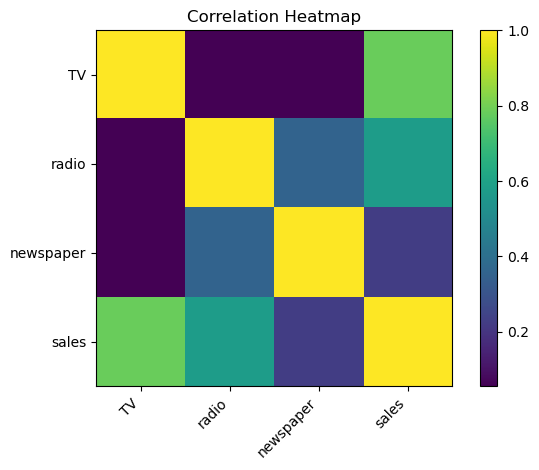

In [6]:

corr = df.corr(numeric_only=True)
display(corr)

# Correlation Heatmap (matplotlib only; no style/colors set)
plt.figure()
plt.imshow(corr, interpolation='nearest')
plt.title("Correlation Heatmap")
plt.xticks(range(len(corr.columns)), corr.columns, rotation=45, ha="right")
plt.yticks(range(len(corr.columns)), corr.columns)
plt.colorbar()
plt.tight_layout()
plt.show()


## Train / Test Split

In [7]:

# Separate features and target
if "sales" not in df.columns:
    raise ValueError("Expected a 'sales' column as the target.")
X = df.drop(columns=["sales"])
y = df["sales"]

# Numeric columns
numeric_features = list(X.select_dtypes(include=[np.number]).columns)

# Split
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42
)
len(X_train), len(X_test)


(160, 40)

## Baseline Model: Linear Regression (with Pipeline)

In [8]:

# Build pipeline: scale numeric features and fit LinearRegression
preprocessor = ColumnTransformer(
    transformers=[("num", StandardScaler(with_mean=True, with_std=True), numeric_features)],
    remainder="drop",
)
linreg = LinearRegression()
pipe = Pipeline(steps=[("prep", preprocessor), ("model", linreg)])

# Fit
pipe.fit(X_train, y_train)

# Predict & evaluate
y_pred = pipe.predict(X_test)

def evaluate(y_true, y_pred):
    r2 = r2_score(y_true, y_pred)
    mae = mean_absolute_error(y_true, y_pred)
    rmse = mean_squared_error(y_true, y_pred, squared=False)
    return {"r2": r2, "mae": mae, "rmse": rmse}

metrics_lr = evaluate(y_test, y_pred)

# Cross-validation on training set for stability
cv_scores = cross_val_score(pipe, X_train, y_train, cv=5, scoring="r2")

print("Linear Regression metrics on test set:", json.dumps(metrics_lr, indent=2))
print("CV R^2 (mean ± std):", np.mean(cv_scores), "±", np.std(cv_scores))


TypeError: got an unexpected keyword argument 'squared'

## Coefficients (Interpretability)

In [ ]:

# Extract coefficients (after scaling)
prep = pipe.named_steps["prep"]
model = pipe.named_steps["model"]

if hasattr(model, "coef_"):
    feature_names = prep.transformers_[0][2]  # numeric features
    coefs = dict(zip(feature_names, model.coef_))
    print("Coefficients (feature -> weight):")
    for k, v in coefs.items():
        print(f"  {k}: {v:.6f}")
else:
    print("Model has no coef_ attribute.")


## Plots

In [ ]:

# Predicted vs Actual
plt.figure()
plt.scatter(y_test, y_pred)
plt.xlabel("Actual Sales")
plt.ylabel("Predicted Sales")
plt.title("Predicted vs Actual")
plt.tight_layout()
plt.show()

# Residuals
residuals = y_test - y_pred
plt.figure()
plt.scatter(y_pred, residuals)
plt.axhline(0)
plt.xlabel("Predicted Sales")
plt.ylabel("Residuals (Actual - Predicted)")
plt.title("Residual Plot")
plt.tight_layout()
plt.show()


## Optional: Ridge Regression with Grid Search

In [ ]:

do_ridge_search = True  # Set to False to skip

best_model = pipe
best_label = "LinearRegression"
best_metrics = metrics_lr
best_params = None

if do_ridge_search:
    ridge = Ridge(random_state=42)
    ridge_pipe = Pipeline(steps=[("prep", preprocessor), ("model", ridge)])
    alphas = np.logspace(-3, 3, 13)
    param_grid = {"model__alpha": alphas}
    gs = GridSearchCV(ridge_pipe, param_grid=param_grid, scoring="r2", cv=5, n_jobs=-1)
    gs.fit(X_train, y_train)
    ridge_pred = gs.predict(X_test)
    metrics_ridge = evaluate(y_test, ridge_pred)
    print("Best Ridge params:", gs.best_params_)
    print("Ridge metrics on test set:", json.dumps(metrics_ridge, indent=2))

    # Choose better by test R^2
    if metrics_ridge["r2"] > best_metrics["r2"]:
        best_model = gs.best_estimator_
        best_label = "Ridge"
        best_metrics = metrics_ridge
        best_params = gs.best_params_

print("Best model:", best_label)
if best_params:
    print("Best params:", best_params)
print("Best model test metrics:", json.dumps(best_metrics, indent=2))


## Save the Best Model

In [ ]:

MODEL_PATH = "/mnt/data/advertising_model.joblib"
import joblib
joblib.dump(best_model, MODEL_PATH)
MODEL_PATH
